# Data Visualization with Birthdate Dataset

This notebook consists of several methods of data analysis and visualization using a dataset of births by date in the United States. The dataset is publically available and provided by the CDC, though this project will use a prepared csv file from Jake VanderPlas. This project was initally meant to be a practice in data cleaning/visualization and was inspired by an example from Jake VanderPlas' book, the Python Data Science Handbook. The first few cells follow along his process for preparing and charting the data. However, I was inspired by other examples using birthrate data and decided to create several more visualizations independently. Namely, this consisted of adjusting the data to be in a relative frequency format centered at 100, plotting the new dataset, and creating a heatmap of mean birth frequency by date.

In [1]:
import requests
import pandas as pd


#births_df = pd.DataFrame([x.split(',') for x in data.split('\n')[1:]])

births_df = pd.read_csv('https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv')
print(births_df.head())
print(len(births_df))

   year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548
15547


## Data preprocessing

After importing the dataset and initial necessary modules, the next step consisted of cleaning the data. Calling _.max()_ on the day column of the dataframe revealed that there was at least one date which was erroneously entered with a day value of 99. To identify null values, I defined a function, _nullday()_ which would iterate through the rows of the dataframe and return a count of all rows with a null value in the 'day' column. Calling the function revealed a total of 480 null rows (out of 15,000). This was easily remedied by calling the Pandas _.dropna()_ function on the dataframe. To fix the erroneous date values, I utilized the sigma-clipping method discussed in the Data Science Handbook. Sigma clipping is a relatively simple method of reducing noise in a dataset by calculating the standard deviation ($\sigma$) and the median ($\mu$), and then removing any points larger or smaller than $\mu\pm\alpha\sigma$, where $\alpha$ is set to 5 in this case. After this the _.astype()_ method was used to cast the 'day' column to the integer datatype. The final adjustment was the addition of a date index, which would make working with the time series data easier. 

In [2]:
#identifying errors in dataframe:
print(births_df.day.max())

def nullday(df):
    null_count = 0
    for row in df.day.isnull():
        if row == True:
            null_count += 1
    return null_count
print(nullday(births_df))

births_df = births_df.dropna()

#using sigma-clipping to remove outliers:
import numpy as np
quartiles = np.percentile(births_df['births'], [25, 50, 75])
mu = quartiles[1]
sigma = 0.74 * (quartiles[2] - quartiles[0])
births_df = births_df.query('(births > @mu - 5 * @sigma) & (births < @mu + 5 * @sigma)')

births_df['day'] = births_df['day'].astype(int)

#creating a Date index:
births_df.index = pd.to_datetime(10000 * births_df.year + 100 * births_df.month + births_df.day, format='%Y%m%d')
births_df['dayofweek'] = births_df.index.dayofweek

print(births_df.head())

99.0
480
            year  month  day gender  births  dayofweek
1969-01-01  1969      1    1      F    4046          2
1969-01-01  1969      1    1      M    4440          2
1969-01-02  1969      1    2      F    4454          3
1969-01-02  1969      1    2      M    4548          3
1969-01-03  1969      1    3      F    4548          4


In [3]:
#mean births by date:
births_by_date = births_df.pivot_table('births', [births_df.index.month, births_df.index.day])

#index by date to make plotting easier (using leap year):
births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]
print(births_by_date.head())

              births
2012-01-01  4009.225
2012-01-02  4247.400
2012-01-03  4500.900
2012-01-04  4571.350
2012-01-05  4603.625


<ipython-input-3-b0618bfef6d8>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]


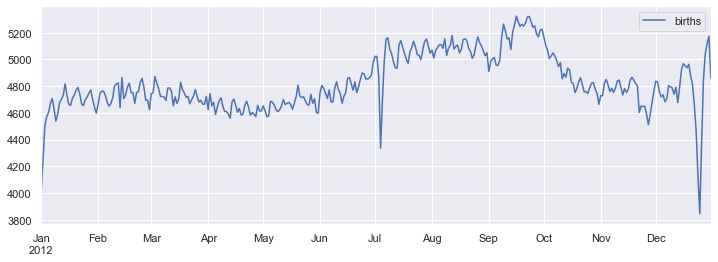

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)
plt.show()

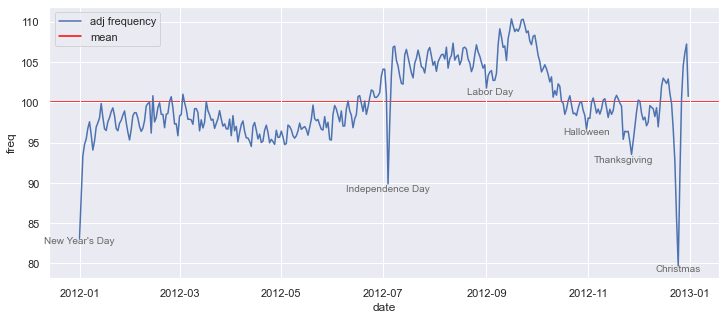

In [11]:
#adjusting births values so that they are normalized with mean=100
mean = births_by_date.births.mean()
birthdate_freq = births_by_date.births.apply(lambda x: 100 * (x / mean)).reset_index()
birthdate_freq.rename(columns={'index':'date', 'births':'freq'}, inplace=True)
#print(birthdate_freq.head(10))

#plotting adjusted frequency graph and mean:
fig1, ax1 = plt.subplots(figsize=(12,5))
sns.lineplot(x='date', y='freq', data=birthdate_freq)
plt.axhline(y=100, c='red', zorder=0)
plt.legend(['adj frequency', 'mean'])

#adding date labels:
style = dict(size=10, color='dimgray')
ax1.text(birthdate_freq.date[0], 82.5, 'New Year\'s Day', ha='center', **style)
ax1.text(birthdate_freq.date[185], 89, 'Independence Day', ha='center', **style)
ax1.text(birthdate_freq.date[246], 101, 'Labor Day', ha='center',**style)
ax1.text(birthdate_freq.date[304], 96, 'Halloween', ha='center', **style)
ax1.text(birthdate_freq.date[326], 92.5, 'Thanksgiving', ha='center', **style)
ax1.text(birthdate_freq.date[359], 79, 'Christmas', ha='center', **style)
plt.show()

# Boxplot of Birthrate by Month

To illustrate the trends in birth frequency on a month-by-month basis, my next step was to create a boxplot of the data using the Seaborn _.boxplot_ method. I used a copy of the original __births_by_date__ dataframe which was modified to include a month column using a lambda function. The data was then grouped by month and plotted along with the appropriate x-labels. The boxplot format was useful for revealing several elements of the dataset; primarily it shows which months had a larger interquartile range and thus more day-to-day variance in birth frequency. September, October, and December appear to have the largest IQR, while April, May, and August have the smallest and are therefore more consistent and clustered. The boxplot also shows the outliers which were noticeable in the previous line plots. Interestingly, there appears to be a positive outlier in the month of May, which is also slightly visible in the other graphs. Negative outliers are understandable given reduced birth frequencies on holidays, but a consistent increase in birth frequency across the dataset on this specific day is more perplexing, though it is likely just due to the low IQR for the month. Finally, the boxplot follows the wave-like general trend in frequency which was demonstrated in the previous graphs, with a trough between February and May, and a peak between July and October. 

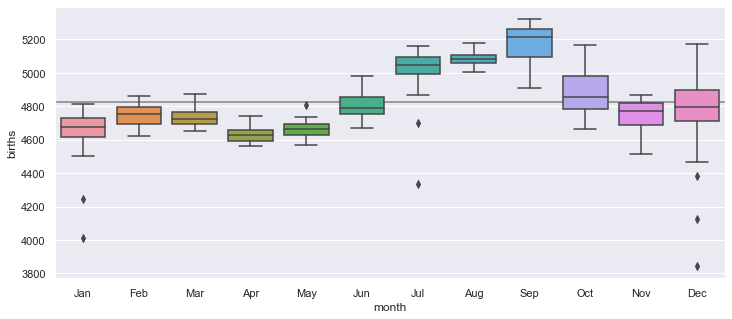

In [10]:
boxplot_data = births_by_date.copy().reset_index()
boxplot_data.rename(columns={'index':'date'}, inplace=True)
boxplot_data['month'] = boxplot_data.date.apply(lambda x: x.month)
#print(boxplot_data.head())
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='month', y='births', data=boxplot_data)
plt.axhline(y=mean, c='grey', zorder=0)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Heatmap of Birth Frequency by Date

Another potential method of visualizing the births dataset is via heatmap (like [this one](http://thedailyviz.com/2016/09/17/how-common-is-your-birthday-dailyviz/)). Therefore I decided to recreate a birthday heatmap on my own using the dataset I had available, which began with some modifications and adjustments to the dataframe.

## Dataframe Adjustments

Since I would be using the adjusted frequency dataset, I started by making a copy of the dataset, which I could modify for the heatmap. This started with isolating the month and day from each row's date index, and turning them into columns in the new dataframe. Once I had a month column, I was then able to pivot the dataframe so that each row was a month's worth of birth frequencies listed in order by day. This pivoted table made it much easier to convert to an arraylist which could be used for the heatmap. I defined the _array_maker_ function to iterate through the table and turn each row (month) into an array and add the array to a list. The array list was then concatenated into the final array, _heatmap_array_ , which would be used as the dataset to be displayed in the heatmap.

In [6]:

#create new df using birthrate_freq which contains isolated columns for month and day:
freq_month_day = birthdate_freq.copy()
freq_month_day['freq'] = round(freq_month_day['freq'], 2)
freq_month_day['month'] = freq_month_day.date.apply(lambda x: x.month)
freq_month_day['day'] = freq_month_day.date.apply(lambda x: x.day)
#print(freq_month_day.head())

#pivot dataframe so that each row is a month:
pivoted = freq_month_day.pivot(columns='day', index='month', values='freq').reset_index()
#print(pivoted.head())

#turn the pivoted dataframe into an arraylist where each array is monthly birthrate values:
def array_maker(df):
    list_of_lists = []
    for i in range(12):
        array = np.array(df.iloc[i])
        array = np.delete(array, [0])
        list_of_lists.append(array)
    return list_of_lists

test = array_maker(pivoted)
heatmap_array = np.array(test)
#print(heatmap_array)

## Creating the Heatmap

Once the data was prepared, it was a relatively simple case of using the _imshow_ module to plot the array as an image. A colorbar was also added for context. From the heatmap we can see the same trends that were displayed in the lineplot, including the cold zones around specific holidays (ie Christmas, New Years, Independence day, etc) and the general spike in birth frequencies between late June and October. A major advantage of the heatmap model is that it is much easier to see specific days, which is significantly harder to do using the line model. Another interesting trend we can see from the heatmap is that the 13th of every month appears 'colder' than its surroundings, likely as a result of superstition.

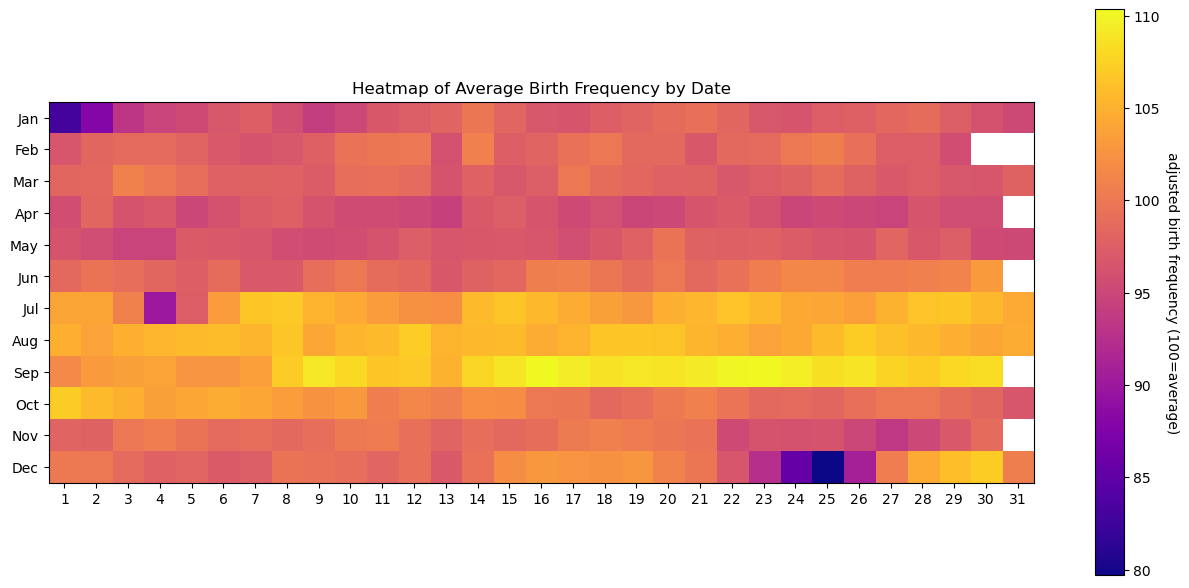

In [10]:
#set up heatmap parameters:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days = list(range(1, 32))

#create heatmap object:
plt.style.use('default')
fig2, ax2 = plt.subplots(figsize=(13, 6))
im = ax2.imshow(heatmap_array, cmap='plasma')

#add colorbar:
cbar = ax.figure.colorbar(im, ax=ax2)
cbar.ax.set_ylabel('adjusted birth frequency (100=average)', rotation=-90, va='bottom')

#set axes and labels:
ax2.set_xticks(np.arange(31))
ax2.set_yticks(np.arange(12))
ax2.set_xticklabels(days)
ax2.set_yticklabels(months)
plt.setp(ax2.get_xticklabels(), ha='center')

ax2.set_title('Heatmap of Average Birth Frequency by Date')
fig2.tight_layout()
plt.show()